# Prelude
Hehe I really liked this activity.

# Acknowledgements
I'd like to thank my instructors, Sir Rene Principe Jr. and Sir Kenneth Leo, for guiding me throughout the activity. I would also like to thank my professor, Ma'am Jing, for guiding me in my coding while my classmates and I worked in R202. I would also like to acknowledge my classmates: Abdel, Johnenn, Jonabel, Richmond, Lovely, Hans, Genesis, Jeruine, Rusher, and Ron for helping me complete this activity.

# Code starts Here

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics as st
from PIL import Image
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
from scipy.stats import gaussian_kde
import os

image_repository = "./Image repository/"
data_repository = "./Collected data/"

# initializing this so I have a placeholder
image = 0

> #### ${\tt thresholding(image, stdev\_mult):}$
> 1. Accepts a grayscale image
> 2. Gets the median and standard deviation of the image.
> 3. Binarizes the image by zeroing out the values that are in the range [median - ${\tt stdev\_mult}\times$(stdev), median + ${\tt stdev\_mult}\times$(stdev)] and setting the other values to $1$.
> 4. Returns the binarized image.<br>
> $~$

In [3]:
def thresholding(image, stdev_mult):

    # I'll automate the thresholding. Since we know that the highest peak in the histogram represents the image's background, 
    # my left and right borders will be np.median(image) -+ stdev_mult*stdev respectively.
    peak_ = np.median(image.flatten())
    stdev_ = np.std(image.flatten())

    # Now setting up the borders
    left_border = int(np.floor(peak_ - stdev_mult*stdev_))
    right_border = int(np.ceil(peak_ + stdev_mult*stdev_))

    # Converting to binary through. The values to the left of the left border and to the right of the right boarder are set to 1.
    T, thresholded = cv2.threshold(image, left_border, right_border, cv2.THRESH_BINARY_INV)

    return thresholded


> #### ${\tt morphing\_time(filename, filetype, commands, record = False, ROI\_size = None,}$ 
> #### ${\tt blob\_numbers = False, bounding\_box = False):}$
> 1. opens the image with the stated ${\tt filename}$.
> 2. Loops through a list of ${\tt commands}$ which contains the morphological operations along with their parameters.
> 3. Displays the original image and the final processed image.
> 4. If ${\tt record}$ is ${\tt True}$, then the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the detected objects are saved to a csv file
> 5. If ${\tt ROI\_size}$ is ${\tt True}$, then the measurements are converted to $\rm{cm}$ or whatever unit you want to set.
> 6. If ${\tt blob\_numbers}$ is ${\tt True}$, then a number is also displayed on the labelled objects.
> 6. If ${\tt bounding\_box}$ is ${\tt True}$, then the detected objects in the original image is enclosed in a box.
> $~$

In [28]:
def morphing_time(filename, filetype,commands, record = False, ROI_size = None, blob_numbers = False, bounding_box = False):
    # Setting initial parameters
    cmap_color = "gray"
    image = cv2.imread(image_repository + filename + filetype)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()

    # This is where the commands are looped through
    for i in range(len(commands)):
        process = commands[i][0].lower()

        match process:
            
            case 'grayscale':       
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            case 'thresholding':
                image = thresholding(image, commands[i][1])
            case 'dilation':
                image = cv2.dilate(image, commands[i][1], iterations = commands[i][2])
            case 'erosion':
                image = cv2.erode(image, commands[i][1], commands[i][2])
            case 'opening':
                image = cv2.morphologyEx(image, cv2.MORPH_OPEN, commands[i][1])
            case 'closing':
                image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, commands[i][1])
            case 'median_blur':
                image = cv2.medianBlur(image, commands[i][1])
            case 'simple_binarize':
                # All pixels beow the boundary ares set to 0 and above are set to 1.
                boundary = np.percentile(image, commands[i][1])
                image[image < boundary] = 0
                image[image >= boundary] = 1  
            case 'invert':
                image= cv2.cv2.bitwise_not(img)
                
            case other:
                print(commands[i][0] + " did nothing lol.")

    # Apply region props and save them to a csv file
    if record == True:
        image = label(image)
        regions = regionprops(image)
        props = regionprops_table(image, properties=('area','centroid', 'bbox', 'perimeter', 'eccentricity' , 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
        data = pd.DataFrame(props)

        # If an ROI_size is given, then the units of the area, axes, and perimeter are converted from pixels to a physical unit.
        if ROI_size != None:
            data.loc[:,"area"] = data.loc[:,"area"] * ROI_size/(len(original_image)*len(original_image[0]))
            data.loc[:,'axis_major_length'] = data.loc[:,'axis_major_length']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
            data.loc[:,'axis_minor_length'] = data.loc[:,'axis_minor_length']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
            data.loc[:,'perimeter'] = data.loc[:,'perimeter']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
        
        # Finally saving to a csv
        data.to_csv(data_repository + filename + ".csv") 
        cmap_color = "viridis"

    # Now graphing everything
    fig, ax = plt.subplots(1,2, figsize = (12,8))
    ax[0].imshow(original_image)
    ax[0].set_title(filename+filetype)

    ax[1].imshow(image, cmap = cmap_color)
    ax[1].set_title("Processed Image")
    
    # For labelling the blob numbers in the output image
    if record == True and blob_numbers == True:
        for i in range(len(data)):
            ax[1].text(data.loc[i,"centroid-1"], data.loc[i,"centroid-0"], i, fontsize = 5.5,bbox=dict(fill=True, facecolor = "white", edgecolor='white', linewidth=0.1))
    
    # For diplaying the bounding box. Source for the code is: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    if record == True and bounding_box == True:
        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax[0].plot(bx, by, '-b', linewidth=2.5)

    plt.tight_layout()
    plt.show()



# Outputs

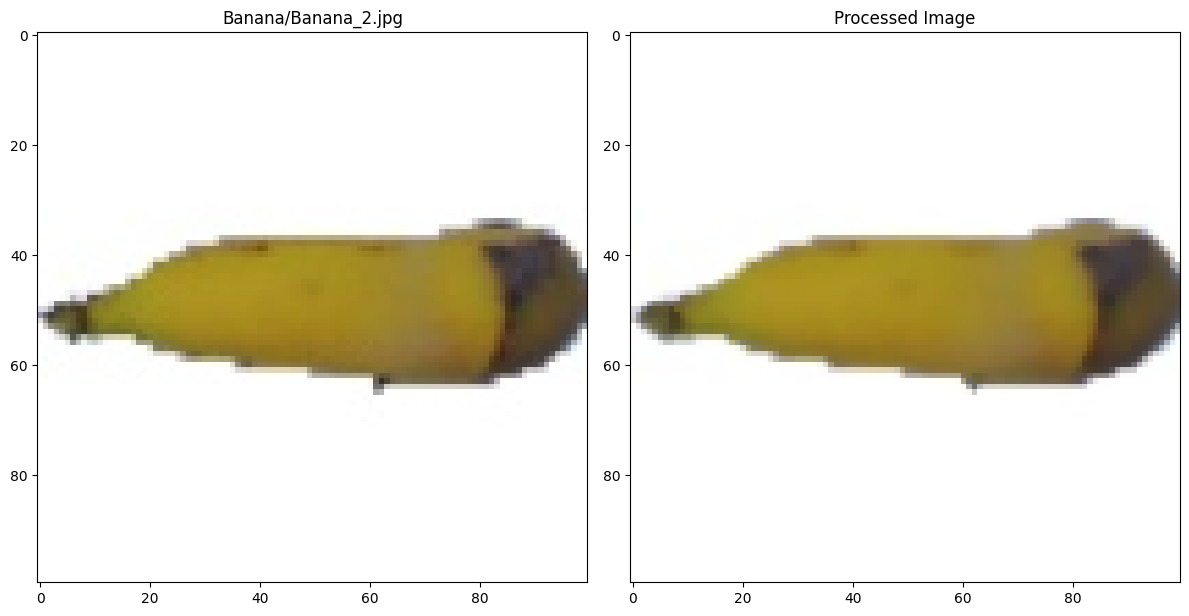

In [29]:
commands = [
            ["median_blur", 3],
]
morphing_time("Banana/Banana_2", ".jpg", commands)

In [ ]:
# for filename in os.listdir(directory):
#     f = os.path.join(directory, filename)
#     # checking if it is a file
#     if os.path.isfile(f):
#         print(f)